### Find Best ensemble

Run this code if you need to find the best ensemble among different models combinations. 
Check "top_model" above in this notebook, it's under the "Ensemble" markdown.

In [6]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

In [7]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 27
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = mean_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/27features/
data/27features/


In [8]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({np.float64(1.0): 3494, np.float64(0.0): 505})
Counter({np.float64(1.0): 1165, np.float64(0.0): 169})
Counter({np.float64(1.0): 1165, np.float64(0.0): 169})


##############################################
 Rank: #1 Names: ['nn', 'gb'], Score: (0.8470782436447674, 0.678006901995577, 0.08123363967811016)
##############################################
 Rank: #2 Names: ['knn', 'nn', 'gb'], Score: (0.8335170277065292, 0.6393503673027996, 0.08285439007704515)
##############################################
 Rank: #3 Names: ['xgb', 'knn', 'nn', 'gb'], Score: (0.8376615790943953, 0.6868008096806331, 0.0834152595814283)
##############################################
 Rank: #4 Names: ['knn', 'nn', 'rf', 'gb'], Score: (0.8375447596312569, 0.6713379060233364, 0.08368824305590915)
##############################################
 Rank: #5 Names: ['xgb', 'svc', 'knn', 'nn', 'gb'], Score: (0.8375193640957919, 0.6373028820010875, 0.0838268646952336)
0.8959739934983746
0.889055472263868
0.8793103448275862


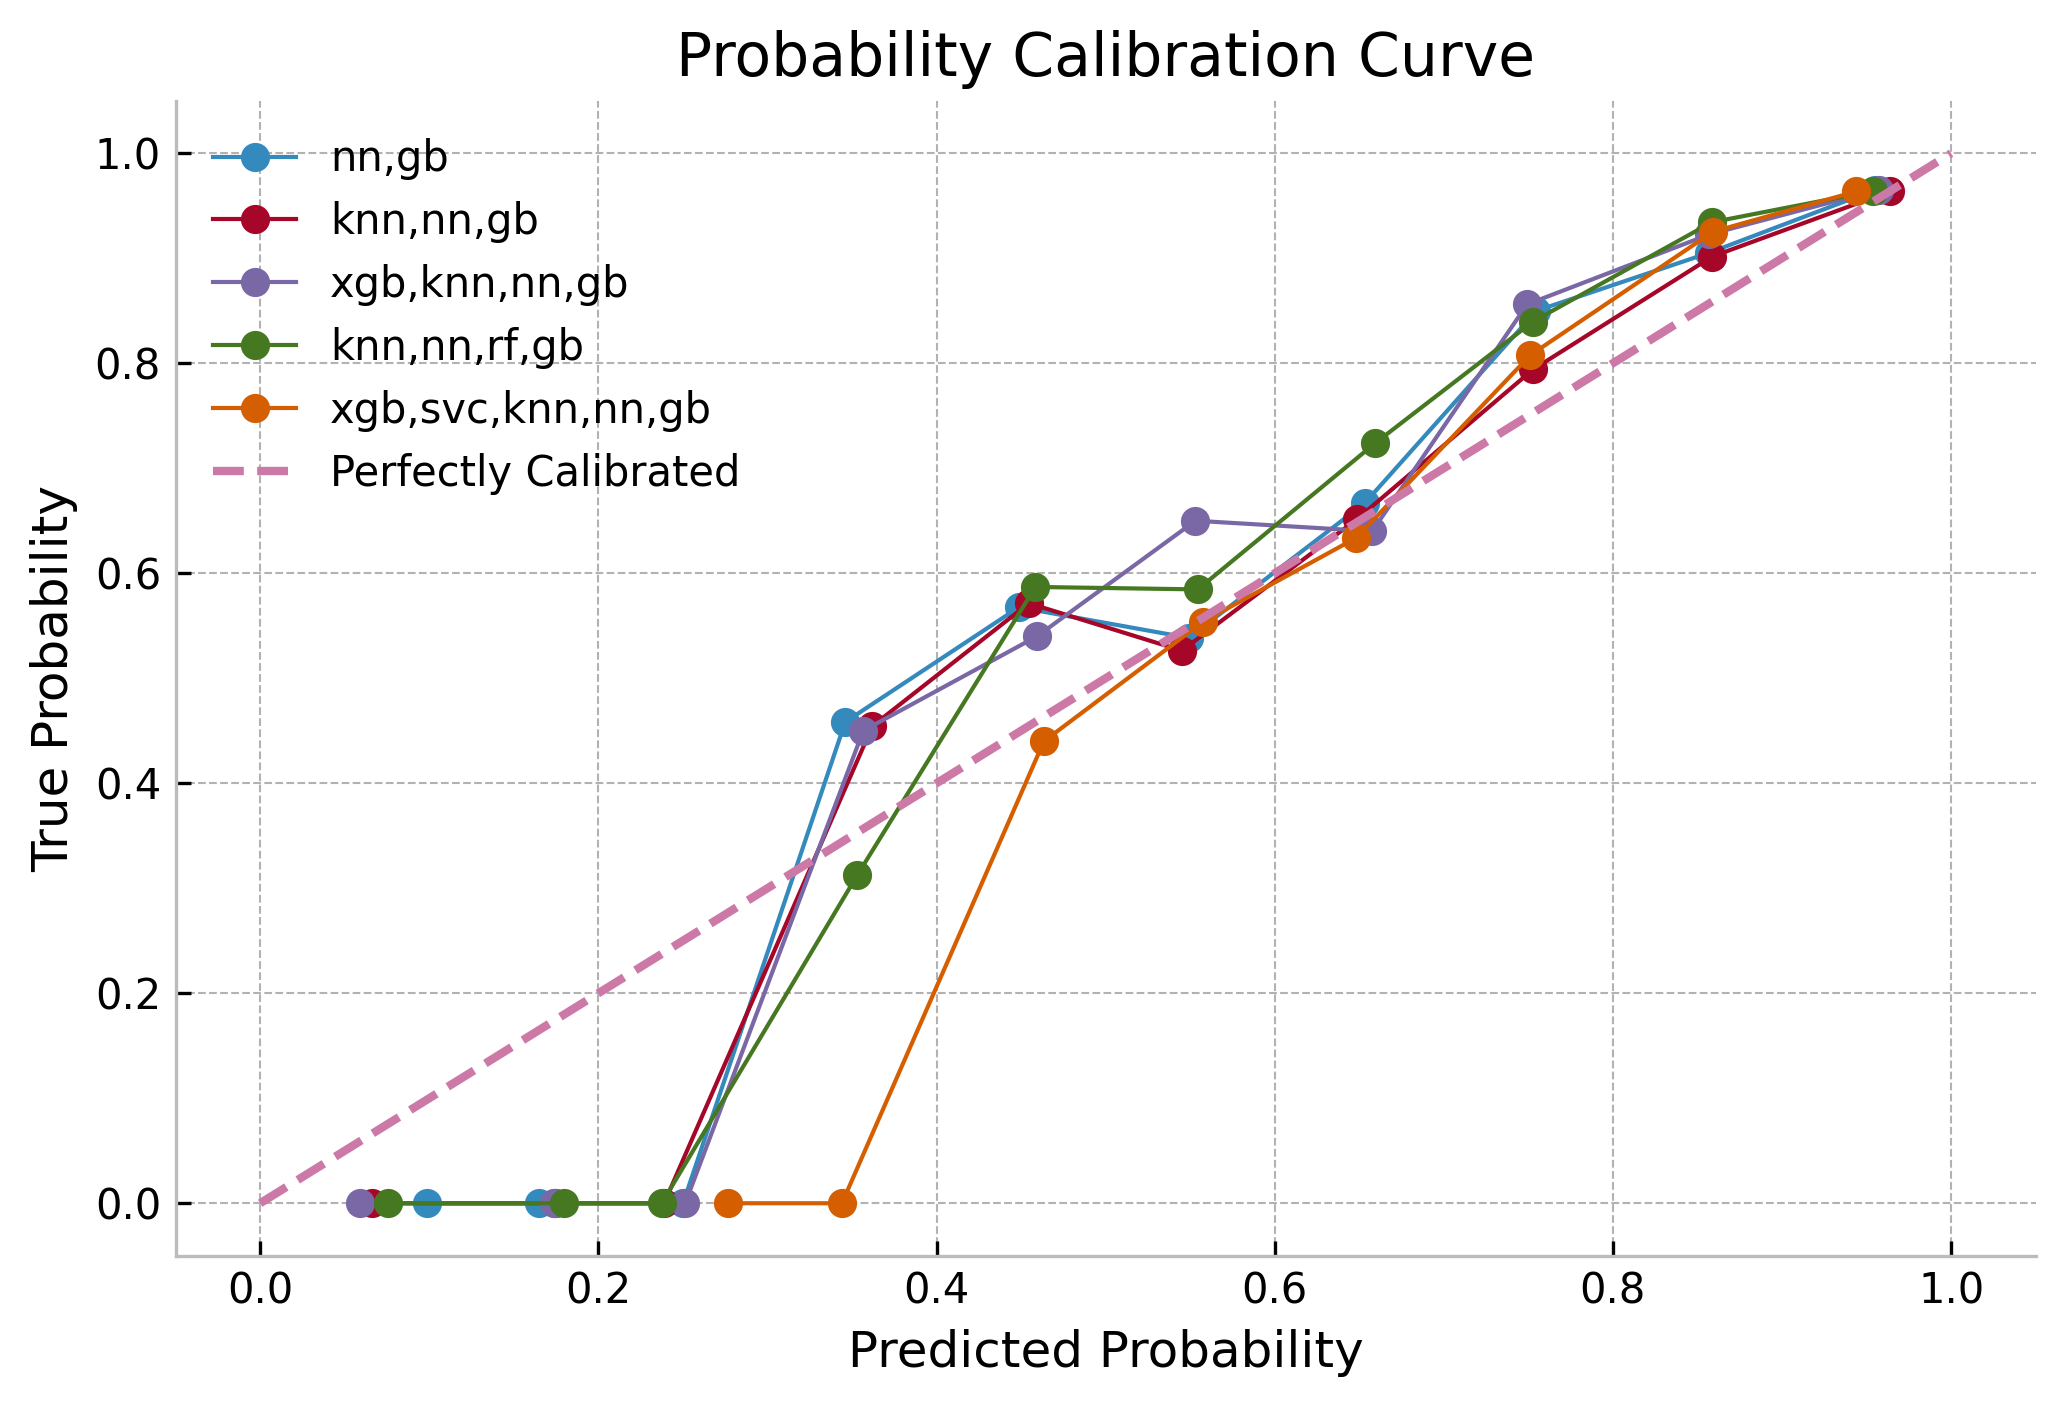

In [9]:
from ensemble import predict_ensemble, find_best_ensemble
from contextlib import redirect_stdout
from joblib import load
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt2
from sklearn.calibration import CalibratedClassifierCV

onlyfiles = [f for f in listdir(path_models) if isfile(join(path_models, f))]
onlyfiles = [model.replace('.joblib', '') for model in onlyfiles]
onlyfiles = [x for x in onlyfiles if not x.startswith('.')]
models = list(filter(lambda x: "random" not in x, onlyfiles))
models = list((x,load(path_models+f"{x}.joblib")) for x in models)
smote_models = list(filter(lambda x: "random" in x, onlyfiles))
smote_models = list((x,load(path_models+f"{x}.joblib")) for x in smote_models)

# Select the list by flipping this variable, this variable it's also used to save the plot in the correct path 
###############
selected = []
selected_models = models
calibrate = False
for name,model in selected_models:
    if calibrate:
        print(f"Calibrating: {name}")
        calibrated_clf = CalibratedClassifierCV(model, cv=5)
        calibrated_clf.fit(X_train, y_train)
        selected.append((name,calibrated_clf))
    else : selected.append((name,model))
###############

ensemble = find_best_ensemble(selected,path_models, X_train, y_train, X_valid, y_valid, False)
valid_prob = None
valid_pred = None
from sklearn.calibration import calibration_curve
for names, model, score in ensemble[:1]:
    train_prob, train_pred = predict_ensemble(model, X_train, y_train)
    valid_prob, valid_pred = predict_ensemble(model, X_valid, y_valid)
    test_prob, test_pred = predict_ensemble(model, X_test, y_test)
    
    print(sum(y_train == train_pred) / len(df_train))
    print(sum(y_valid == valid_pred) / len(df_valid))
    print(sum(y_test == test_pred) / len(df_test))
    
    df_train["ModelOutput"] = train_prob[:, 1]
    df_valid["ModelOutput"] = valid_prob[:, 1]
    df_test["ModelOutput"] = test_prob[:, 1]
    """plt2.hist(valid_prob[:, 1], 
         bins=10,  
         alpha=0.5,  
         label='Calibrated') 
    plt2.legend(loc='upper center') 
    plt2.title('Histogram of Predicted Probabilities') 
    plt2.xlabel('Predicted Probability') 
    plt2.ylabel('Frequency') 
    plt2.show()"""
    ############
for names, model, score in ensemble[:5]:
    valid_prob, valid_pred = predict_ensemble(model, X_valid, y_valid)
    true_pos, pred_pos = calibration_curve(y_valid, valid_prob[:, 1], n_bins=10)
    plt.plot(pred_pos,
             true_pos, 
             marker='o', 
             linewidth=1, 
             label=",".join(names).replace("_random",'')) # Remove random to make names shorter
    
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
suffix = "" if selected_models == models else "_sampling"
suffix += "" if calibrate else "_UNC"
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')
plt.savefig(f"{path_images}calibration_top_five{suffix}.png")
index = 1
with open(f"{path_images}calibration_top_five{suffix}.txt", 'a+') as f:
        with redirect_stdout(f):
            for names, model, score in ensemble[:5]:
                print("##############################################")
                print (f" Rank: #{index} Names: {names}, Score: {score}")
                index +=1

In [10]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)


<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_0/exported_notebooks/3.2_find_best_ensemble_27features_20250929_234210.html
